In [1]:
import numpy as np
import pandas as pd
import os 
import argparse
import pylab as pl
from   glob import glob
from   PIL import Image

import torch
from torch            import nn
from torch            import FloatTensor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn         import functional as F
from torchvision      import transforms, models
from torchvision.models import resnet18
from torchvision.models import resnet50
from torchvision.models import resnet152


from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

pl.style.use('../../plots.mplstyle')

In [2]:
def tensor2img(tensor):
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    img_restore = tensor * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)
    return transforms.ToPILImage()(img_restore)

class ReadDataset(Dataset):

    def __init__(self, predictor_paths, target_paths):
        self.predictor_files = predictor_paths
        self.target_files = target_paths
        
        self.data_transforms = transforms.Compose([
            # transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
    
    def __getitem__(self, index):
        x = np.load(self.predictor_files[index])
        # x = Image.fromarray(x, 'RGB')
        x = self.data_transforms(x)
        
        y = np.load(self.target_files[index])[0:2] #- Get only the first feature 0:Redshift, 1:LogL_5100
        y = torch.tensor(y).float()
        return x, y
    
    def __len__(self):
        return len(self.predictor_files)

    
class GalaxyNet(torch.nn.Module):
    def __init__(self, pretrained=True, model='resnet50'):
        super().__init__()
                
        if model=='resnet18':
            model = resnet18(pretrained=True)
        elif model=='resnet50':
            model = resnet50(pretrained=True)
        elif model=='resnet152':
            model = resnet152(pretrained=True)
        elif model=='vitl16':
            model = vit_l_16(pretrained=True)
        elif model=='vitl32':
            model = vit_l_32(pretrained=True)
        else:
            print('Other model doesnt exist')
        
        count = 0
        for child in model.children():  
            count += 1
            if count < 7:    
                for param in child.parameters():
                    param.requires_grad = False

        # for param in model.parameters():
        #     param.requires_grad = False        
        
        model.load_state_dict(model.state_dict())     
        
        self.features = torch.nn.ModuleList(model.children())[:-1]
        self.features = torch.nn.Sequential(*self.features)
        
        self.fc1 = torch.nn.Linear(model.fc.in_features, 512)
        self.fc2 = torch.nn.Linear(512, 256)
        self.fc3 = torch.nn.Linear(256, 2)
        

    def forward(self, x):
        #-Call Features
        x = self.features(x)
        
        #-Flatten
        x = x.view(x.size(0), -1)
        
        # and also our new layers 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [3]:
def train(model, epoch, dataloader, device, optimizer, criterion):
    model.train()
    
    #- Start the train loop
    for batch_id, (X_batch, Y_batch) in enumerate(dataloader):
        
        #- Send data to device 
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        #- Make the prediction
        Y_pred = model(X_batch).squeeze()

        #- Compute the loss
        loss = criterion(Y_pred, Y_batch)

        #- Back Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1} - Loss_Train:{loss.item():.4f}')        
    return loss.item()

def test(model, epoch, dataloader, device, criterion):
    model.eval()
    
    #- Start the test loop
    for batch_id, (X_batch, Y_batch) in enumerate(dataloader):
        
        #- Send data to device 
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        #- Make the prediction
        Y_pred = model(X_batch).squeeze()

        #- Compute the loss
        loss = criterion(Y_pred, Y_batch)

    print(f'Epoch:{epoch+1} - Loss_Test:{loss.item():.4f}')        
    return loss.item()

In [4]:
catalog = './guadalupe_stats_Z0.5.csv'

data = pd.read_csv(catalog)

img_train_files = data['IMAGE_FILE'][np.array(data['MODEL_LABEL'], dtype=int)==0].values.tolist()
tgt_train_files = [i.replace('photogrz','features') for i in img_train_files]

img_valid_files = data['IMAGE_FILE'][np.array(data['MODEL_LABEL'], dtype=int)==1].values.tolist()
tgt_valid_files = [i.replace('photogrz','features') for i in img_valid_files]

img_test_files = data['IMAGE_FILE'][np.array(data['MODEL_LABEL'], dtype=int)==2].values.tolist()
tgt_test_files = [i.replace('photogrz','features') for i in img_test_files]

#- Number of objects
N = len(img_train_files)+len(img_valid_files)+len(img_test_files)
print(f'#####\n There are {N} objects\n#####')

print(f'#######\n Train Size: {len(img_train_files)}')
print(f' Valid  Size: {len(img_valid_files)}')
print(f' Test  Size: {len(img_test_files)}\n#######')

train_dataset = ReadDataset(img_train_files, tgt_train_files)
valid_dataset = ReadDataset(img_valid_files, tgt_valid_files)
test_dataset  = ReadDataset(img_test_files,  tgt_test_files)

#####
 There are 182624 objects
#####
#######
 Train Size: 127836
 Valid  Size: 36525
 Test  Size: 18263
#######


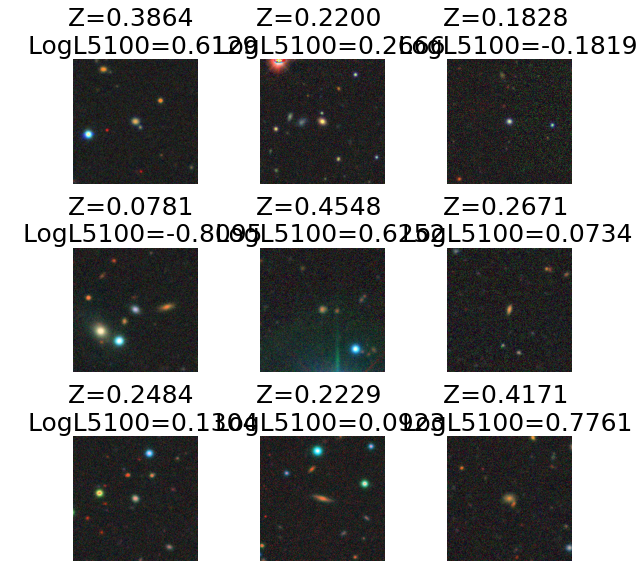

In [5]:
figure = pl.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, tgt = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    pl.title(f'Z={tgt[0]:.4f} \n  LogL5100={tgt[1]:.4f}')
    pl.axis("off")
    pl.imshow(tensor2img(img))
pl.tight_layout()
pl.show()

In [6]:
def main():
    #- Set parameters
#     parser = argparse.ArgumentParser()
#     parser.add_argument('--lr', type=float, default=1e-2,
#                         help='Initial learning rate (default: 1e-3)')
    
#     parser.add_argument('--epochs', type=int, default=100,
#                         help='Maximum number of epochs (default: 300)')
    
#     parser.add_argument('--batch', type=int, default=16,
#                         help='Batch size (default: 13)')
    
#     parser.add_argument('--name', type=str, default='Test',
#                         help='Name of the current test (default: Test)')
    
#     parser.add_argument('--kernel', type=int, default=10,
#                         help='Kernel Size')
    
#     parser.add_argument('--dropout', type=float, default=0.3, 
#                         help='Dropout probability')
    
#     parser.add_argument('--model', type=str, default='resnet50',
#                         help='cnn/resnet')
    
#     parser.add_argument('--label', type=str, default='Test',
#                         help='Label to compare runnings')
    
#     parser.add_argument('--catalog', type=str, default=None, 
#                         help='Name of the folder with the data')
    
    #parser.add_argument('--load_model', type=str, default='best_f1', help='Weights to load (default: best_f1)')
    #parser.add_argument('--test', action='store_false', default=True, help='Only test the model')
    #parser.add_argument('--resume', action='store_true', default=False, help='Continue training a model')
    #parser.add_argument('--ft', action='store_true', default=False, help='Fine-tune a model')
    #parser.add_argument('--freeze', action='store_false', default=True, help='Freeze weights of the model')
    #parser.add_argument('--gpu', type=str, default='0', help='GPU(s) to use (default: 0)')
    #parser.add_argument('--amp', action='store_true', default=False,help='Train with automatic mixed precision')
    
    # args = parser.parse_args()   
    
    name    = 'Test'
    label   = 'Test'
    catalog = './guadalupe_stats_Z0.5.csv'
    batch   = 16
    model   = 'resnet50'
    epochs  = 1
    lr      = 0.1
    
    save_path = os.path.join('train', name, label)
    if not os.path.isdir(save_path):
        os.makedirs(save_path, exist_ok=True)
    
    data = pd.read_csv(catalog)

    img_train_files = data['IMAGE_FILE'][np.array(data['MODEL_LABEL'], dtype=int)==0].values.tolist()
    tgt_train_files = [i.replace('photogrz','features') for i in img_train_files]

    img_valid_files = data['IMAGE_FILE'][np.array(data['MODEL_LABEL'], dtype=int)==1].values.tolist()
    tgt_valid_files = [i.replace('photogrz','features') for i in img_valid_files]

    img_test_files = data['IMAGE_FILE'][np.array(data['MODEL_LABEL'], dtype=int)==2].values.tolist()
    tgt_test_files = [i.replace('photogrz','features') for i in img_test_files]

    #- Number of objects
    N = len(img_train_files)+len(img_valid_files)+len(img_test_files)
    print(f'#####\n There are {N} objects\n#####')

    print(f'#######\n Train Size: {len(img_train_files)}')
    print(f' Valid  Size: {len(img_valid_files)}')
    print(f' Test  Size: {len(img_test_files)}\n#######')

    train_dataset = ReadDataset(img_train_files, tgt_train_files)
    valid_dataset = ReadDataset(img_valid_files, tgt_valid_files)
    test_dataset  = ReadDataset(img_test_files,  tgt_test_files)

    # sample_idx = torch.randint(0, len(train_dataset), size=(9,)).detach().numpy()
    # figure = pl.figure(figsize=(8, 8))
    # cols, rows = 3, 3
    # for i in range(0, cols * rows):
    #     spec, tgt = train_dataset[sample_idx[i]]
    #     figure.add_subplot(rows, cols, i+1)
    #     pl.title(f'Z {tgt.item():.4f}')
    #     pl.plot(spec.squeeze())
    # print(f'Size {len(spec.squeeze())}')
    # pl.tight_layout()
    # pl.savefig()
    # pl.show()

    
    #- Define the batch_size
    batch_size = batch
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_dataloader  = DataLoader(valid_dataset,  batch_size=batch_size , shuffle=True)
    test_dataloader  = DataLoader(test_dataset,  batch_size=batch_size , shuffle=True)
    
    # train_features, train_labels = next(iter(train_dataloader))
    #- Display image and label
    # spec = train_features[0].squeeze().detach().numpy()
    # label = train_labels[0].item()
    # pl.title(f'Z {label:.4f}')
    # pl.plot(spec)
    # pl.show()

    #- Define the device cpu/gpu
    device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
    print(device)

    #- Define the model
    model = GalaxyNet(model)

    #- Send the model to the device
    model = model.to(device)
    
    #- Define the optimizer and the criterion
    optimizer = torch.optim.SGD(model.parameters(), lr=lr) 
    criterion = torch.nn.MSELoss()

    loss_train = []
    loss_valid  = []
    
    #- Running name
    name = name
    for epoch in range(epochs):
        loss_train.append( train(model, epoch, train_dataloader, device, optimizer, criterion) )
        loss_valid.append(  test(model, epoch, valid_dataloader, device, criterion) )

    fig = pl.figure(figsize=(8,4))
    pl.plot(loss_train, label='Train')
    pl.plot(loss_valid, label='Valid')
    pl.legend()
    pl.savefig(f'{save_path}/Loss_RegPhoto_{name}.png', bbox_inches='tight')
    # pl.show()

    torch.save(model, f'{save_path}/{name}.pt')    
    
    #- Put the model on test mode
    model.eval()
    with torch.no_grad():
        Y_pred = []
        Y_test = []
        for batch_idx, (data, target) in enumerate(test_dataloader):   
            data = FloatTensor(data)
            target = FloatTensor(target)
            data   = data.to(device)
            target = target.to(device)        
            Y_pred.append(model(data).cpu().squeeze().detach().numpy())
            Y_test.append(target.cpu().detach().numpy())
        Y_predtest = np.concatenate([i for i in Y_pred])
        Y_test = np.concatenate([i for i in Y_test])

        Y_pred = []
        Y_train = []    
        for batch_idx, (data, target) in enumerate(train_dataloader):    
            data = FloatTensor(data)
            target = FloatTensor(target)
            data   = data.to(device)
            target = target.to(device)        
            Y_pred.append(model(data).cpu().squeeze().detach().numpy())
            Y_train.append(target.cpu().detach().numpy())
        Y_predtrain = np.concatenate([i for i in Y_pred])
        Y_train = np.concatenate([i for i in Y_train])

    fig = pl.figure(figsize=(20,15))
    pl.subplot(2,3,1)
    pl.scatter(Y_predtest[:,0], Y_test[:,0], alpha=0.5)
    maxx = max(max(Y_predtest[:,0]),max(Y_test[:,0]))
    pl.plot([0, maxx], [0, maxx], '--')
    pl.xlabel(r'$z_{pred}$')
    pl.ylabel(r'$z_{test}$')
    pl.title(r'$z_{pred}$ - $z_{test}$'+f'\n'+r'$r^2$'+f'={r2_score(Y_test[:,0], Y_predtest[:,0]):.3f}   -    MSE={mean_squared_error(Y_test[:,0], Y_predtest[:,0]):.4f}')
    pl.subplot(2,3,2)
    _ = pl.hist(Y_predtest[:,0] - Y_test[:,0], label=r'$z_{pred}$ - $z_{test}$', alpha=0.5)
    pl.legend()
    pl.subplot(2,3,3)
    _ = pl.hist(Y_predtest[:,0], label='Pred', alpha=0.5)
    _ = pl.hist(Y_test[:,0], label='Test', alpha=0.5)
    pl.legend()
    pl.subplot(2,3,4)
    pl.scatter(Y_predtest[:,1], Y_test[:,1], alpha=0.5)
    maxx = max(max(Y_predtest[:,1]),max(Y_test[:,1]))
    minn = min(min(Y_predtest[:,1]),min(Y_test[:,1]))
    pl.plot([minn, maxx], [minn, maxx], '--')
    pl.xlabel(r'$LogL5100_{pred}$')
    pl.ylabel(r'$LogL5100_{test}$')
    pl.title(r'$LogL5100_{pred}$ - $LogL5100_{test}$'+f'\n'+r'$r^2$'+f'={r2_score(Y_test[:,1], Y_predtest[:,1]):.3f}   -    MSE={mean_squared_error(Y_test[:,1], Y_predtest[:,1]):.4f}')
    pl.subplot(2,3,5)
    _ = pl.hist(Y_predtest[:,1] - Y_test[:,1], label=r'$LogL5100_{pred}$ - $LogL5100_{test}$', alpha=0.5)
    pl.legend()
    pl.subplot(2,3,6)
    _ = pl.hist(Y_predtest[:,1], label='Pred', alpha=0.5)
    _ = pl.hist(Y_test[:,1], label='Test', alpha=0.5)
    pl.legend()
    pl.tight_layout()
    pl.show()
    # pl.savefig(f'{save_path}/RegPhoto_test_{name}.png', bbox_inches='tight')

    fig = pl.figure(figsize=(20,15))
    pl.subplot(2,3,1)
    pl.scatter(Y_predtrain[:,0], Y_train[:,0], alpha=0.5)
    maxx = max(max(Y_predtrain[:,0]),max(Y_train[:,0]))
    pl.plot([0, maxx], [0, maxx], '--')
    pl.xlabel(r'$z_{pred}$')
    pl.ylabel(r'$z_{train}$')
    pl.title(r'$z_{pred}$ - $z_{train}$'+f'\n'+r'$r^2$'+f'={r2_score(Y_train[:,0], Y_predtrain[:,0]):.3f}   -    MSE={mean_squared_error(Y_train[:,0], Y_predtrain[:,0]):.4f}')
    pl.subplot(2,3,2)
    _ = pl.hist(Y_predtrain[:,0] - Y_train[:,0], label=r'$z_{pred}$ - $z_{train}$', alpha=0.5)
    pl.legend()
    pl.subplot(2,3,3)
    _ = pl.hist(Y_predtrain[:,0], label='Pred', alpha=0.5)
    _ = pl.hist(Y_train[:,0], label='Train', alpha=0.5)
    pl.legend()
    pl.subplot(2,3,4)
    pl.scatter(Y_predtrain[:,1], Y_train[:,1], alpha=0.5)
    maxx = max(max(Y_predtrain[:,1]),max(Y_train[:,1]))
    minn = min(min(Y_predtrain[:,1]),min(Y_train[:,1]))
    pl.plot([minn, maxx], [minn, maxx], '--')
    pl.xlabel(r'$LogL5100_{pred}$')
    pl.ylabel(r'$LogL5100_{train}$')
    pl.title(r'$LogL5100_{pred}$ - $LogL5100_{train}$'+f'\n'+r'$r^2$'+f'={r2_score(Y_train[:,1], Y_predtrain[:,1]):.3f}   -    MSE={mean_squared_error(Y_train[:,1], Y_predtrain[:,1]):.4f}')
    pl.subplot(2,3,5)
    _ = pl.hist(Y_predtrain[:,1] - Y_train[:,1], label=r'$LogL5100_{pred}$ - $LogL5100_{train}$', alpha=0.5)
    pl.legend()
    pl.subplot(2,3,6)
    _ = pl.hist(Y_predtrain[:,1], label='Pred', alpha=0.5)
    _ = pl.hist(Y_train[:,1], label='Train', alpha=0.5)
    pl.legend()
    pl.tight_layout()
    pl.show()
    # pl.savefig(f'{save_path}/RegPhoto_train{name}.png', bbox_inches='tight')

In [7]:
if __name__ == '__main__':
    main()

#####
 There are 182624 objects
#####
#######
 Train Size: 127836
 Valid  Size: 36525
 Test  Size: 18263
#######
cuda:0


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.